In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
from itertools import product
from functools import partial, update_wrapper
import numpy as np
import time
import numpy as np
import gc
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
def scale(x):

    return x / np.max(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [4]:
#os.chdir("/Users/michelkauffmann/Downloads")
u = preprocess(scale(loadmat('u_F_xyz_T1.mat')["u_F"]))
v = preprocess(scale(loadmat('v_F_xyz_T1.mat')["v_F"]))
w = preprocess(scale(loadmat('w_F_xyz_T1.mat')["w_F"]))
tau_11 = preprocess(scale(loadmat('tau11_xyz_T1.mat')["tau11"]))
tau_12 = preprocess(scale(loadmat('tau12_xyz_T1.mat')["tau12"]))
tau_13 = preprocess(scale(loadmat('tau13_xyz_T1.mat')["tau13"]))
tau_22 = preprocess(scale(loadmat('tau22_xyz_T1.mat')["tau22"]))
tau_23 = preprocess(scale(loadmat('tau23_xyz_T1.mat')["tau23"]))
tau_33 = preprocess(scale(loadmat('tau33_xyz_T1.mat')["tau33"]))
tke = preprocess(scale(loadmat("TKE_F_xyz_T1.mat")["TKE_F"]))
theta = preprocess(scale(loadmat("theta_F_xyz_T1.mat")["theta_F"]))

#### Switches

In [5]:
all_taus = False
significance = True

### 1. Generae Input datasets

#### 1.1 Create Input dataset (u, v, w, TKE, $\theta$)

In [6]:
x = np.array([u, v, w, tke, theta])
x = np.transpose(x, [1, 2, 3, 0])
x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)

In [7]:
sample = []
size = 3
y_tau_11 = []
y_tau_12 = []
y_tau_13 = []
y_tau_22 = []
y_tau_23 = []
y_tau_33 = []
for i in tqdm_notebook(range(size, x.shape[0] - size)):
    for j in range(size, x.shape[1] - size):
        for k in range(size, x.shape[2] - size):
            sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            y_tau_11.append(tau_11[i - size][j - size][k - size])
            y_tau_12.append(tau_12[i - size][j - size][k - size])
            y_tau_13.append(tau_13[i - size][j - size][k - size])
            y_tau_22.append(tau_22[i - size][j - size][k - size])
            y_tau_23.append(tau_23[i - size][j - size][k - size])
            y_tau_33.append(tau_33[i - size][j - size][k - size])

In [8]:
x = np.array(sample)
print(x.shape)

y_tau_11 = np.array(y_tau_11)
y_tau_12 = np.array(y_tau_12)
y_tau_13 = np.array(y_tau_13)
y_tau_22 = np.array(y_tau_22)
y_tau_23 = np.array(y_tau_23)
y_tau_33 = np.array(y_tau_33)

(784896, 7, 7, 7, 5)


#### 1.2 Create Input Dataset (u, v, w, $\theta$)

In [9]:
x_theta = np.delete(x, 3, 4)
print(x_theta.shape)

(784896, 7, 7, 7, 4)


#### 1.3 Create Input Dataset (u, v, w, TKE) 

In [10]:
x_tke = np.delete(x, 4, 4)
print(x_tke.shape)

(784896, 7, 7, 7, 4)


#### 1.4 Create Dataset (u, v, w)

In [11]:
x_base = np.delete(x, (3,4), 4)
print(x_base.shape)

(784896, 7, 7, 7, 3)


### 2. Build Model 

In [12]:
class DNN(object):
    
    def __init__(self, activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, val_split):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.val_split = val_split
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Flatten(input_shape = self.input_shape),
            #tf.keras.layers.Dense(256, 
            #                 activation = self.activation, 
            #                 kernel_regularizer = self.regularizer, 
            #                 kernel_initializer = self.initializer),
            #tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(1)
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.001,
                                               patience = 0,
                                               verbose = 0)
        
        return early_stopping
    
    def correlation_loss(self):
        
        def loss(y_true, y_pred):
            """
            # scale predictions so that the class probas of each sample sum to 1
            y_pred_mean= K.mean(y_pred, axis=0, keepdims=True)
            y_treu_mean = K.mean(y_true, axis=0, keepdims=True)
            # clip to prevent NaN's and Inf's
            part1 = y_pred-y_pred_mean
            part2 = y_true - y_treu_mean
            loss = K.sum(part1*part2,axis = 0)/K.sum(part1*part1,axis = 0)*K.sum(part2*part2,axis = 0)

            return -loss
            """
            x = y_true
            y = y_pred
            mx = K.mean(x)
            my = K.mean(y)
            xm, ym = x-mx, y-my
            r_num = K.sum(tf.multiply(xm,ym))
            r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
            r = r_num / r_den

            r = K.maximum(K.minimum(r, 1.0), -1.0)
            
            return 1 - K.square(r)
            
        return loss
    
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = self.correlation_loss())
              #metrics = ['mse'])
        
        tf.keras.backend.get_session().run(tf.initialize_all_variables())
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    validation_split = self.val_split, 
                    batch_size =  self.batch_size,
                    verbose = 1)
                    #callbacks = [self.callbacks()])
        
        return history, model

### 3. Run Model

In [ ]:
if significance:
    activation = tf.nn.relu
    initializer = None
    regularizer = None
    epochs = 50
    batch_size = 1000
    val_split = 0.2

    datasets = [(x_base, "x_base")]#, (x_tke, "x_tke"), (x_theta, "x_theta")]
    fig = plt.figure(figsize = (20, 6))
    results = {}
    i = 1
    for (x, name) in datasets:
        print("Using " + name + " as input")
        mask =  np.random.rand(x.shape[0]) < 0.80
        y_train, y_test = y_tau_11[mask], y_tau_11[~mask]
        x_train, x_test = x[mask,:,:,:,:], x[~mask,:,:,:,:]

        input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4])
        model = DNN(activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, val_split)        
        history, model = model.run_model()
        
        fig.add_subplot(1, len(datasets), i)
        plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error')
        #plt.ylim((0, 0.002))
        plt.legend()

        y_pred = model.predict(x_test).flatten()
        y_true = y_test
        print("R^2: %.4f" % r2_score(y_true, y_pred))
        print("Correlation: %.4f\n" % np.corrcoef(y_pred, y_true)[0, 1])
        results[np.corrcoef(y_pred, y_true)[0, 1]] = x
        
        del x_train
        del x_test
        del y_train
        del y_test
        gc.collect()
        i += 1

    plt.show()

Using x_base as input
Train on 502774 samples, validate on 125694 samples
Epoch 1/10
502774/502774 [==============================] - 6s 13us/step - loss: 0.4131 - val_loss: 0.3539
Epoch 2/10
502774/502774 [==============================] - 6s 12us/step - loss: 0.3447 - val_loss: 0.3265
Epoch 3/10
502774/502774 [==============================] - 6s 12us/step - loss: 0.3158 - val_loss: 0.3099
Epoch 4/10
 17000/502774 [>.............................] - ETA: 5s - loss: 0.3047

In [14]:
x_best = results[max(results)]

Predicting tau_12
R^2: -37.2639
Correlation: -0.7640
Saved model to disk

Predicting tau_13


KeyboardInterrupt: 

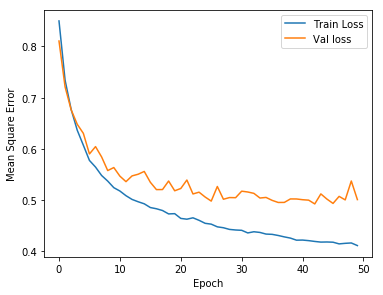

In [16]:
if all_taus:
    taus = [(y_tau_11, "tau_11"), (y_tau_12, "tau_12"), (y_tau_13, "tau_13"), (y_tau_22, "tau_22"), (y_tau_23, "tau_23"), (y_tau_33, "tau_33")]
else:
    taus = [(y_tau_12, "tau_12"), (y_tau_13, "tau_13"), (y_tau_23, "tau_23")]
    
activation = tf.nn.relu
initializer = None
regularizer = None
epochs = 50
batch_size = 1000
input_shape = (x_best.shape[1], x_best.shape[2], x_best.shape[3], x_best.shape[4])
val_split = 0.2

fig = plt.figure(figsize = (20, 10))

i = 1
for (y, name) in taus:
    print("Predicting " + name)
    mask =  np.random.rand(x.shape[0]) < 0.80
    x_train, x_test = x_best[mask,:,:,:,:], x_best[~mask,:,:,:,:]
    y_train, y_test = y[mask], y[~mask]
    
    model = DNN(activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, val_split)
    history, model = model.run_model()
    fig.add_subplot(2, 3, i)
    plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    #plt.ylim((0, 0.05))
    plt.legend()
    
    y_pred = model.predict(x_test).flatten()
    y_true = y_test
    print("R^2: %.4f" % r2_score(y_true, y_pred))
    print("Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
    
    model_name_json = "model_" + name + ".json"
    model_name_h5 = "model_" + name + ".h5"
    model_json = model.to_json()
    with open(model_name_json, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_name_h5)
    print("Saved model to disk\n")
    
    del x_train
    del x_test
    del y_train
    del y_test
    gc.collect()
    i += 1

plt.show()